In [1]:
import pandas as pd
import pandas_profiling as pf
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data Exploration

In [2]:
data = pd.read_csv('DataInsightAnalystTestSalesPipeline.csv')
data.head()

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


In [3]:
print(data.shape, data['Opportunity Number'].nunique())

(78025, 19) 77829


There are duplicate values in the column 'Opportunity Number', so it seems this column is not the unique ID

In [4]:
# Analyse data profile
pf.ProfileReport(data)

Number of variables,19
Number of observations,78025
Total Missing (%),0.0%
Total size in memory,11.3 MiB
Average record size in memory,152.0 B
Numeric,12
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [7]:
def plot_success_rate(X, y):
    '''
    plot success rates for each value of binned / categorical variable
    along with number of samples in that bucket
    '''

    for col in X.select_dtypes(include='number').columns:
        bins = pd.qcut(X[col], 20, duplicates='drop')
        success_rate = pd.concat([bins, y], axis=1).groupby(col).y.mean()
#         plt.bar(success_rate.index, success_rate)
        success_rate.plot(kind='bar')
        val_counts = bins.value_counts().sort_index()
        ax = plt.gca().twinx()
        ax.plot(val_counts.index.astype(str), val_counts)
        plt.show()
    for col in X.select_dtypes(exclude='number').columns:
        success_rate = pd.concat([X[col], y], axis=1).groupby(col).y.mean()
        success_rate.plot(kind='bar')
        val_counts = X[col].value_counts().sort_index()
        ax = plt.gca().twinx()
        ax.plot(val_counts.index.astype(str), val_counts)
        plt.show()        

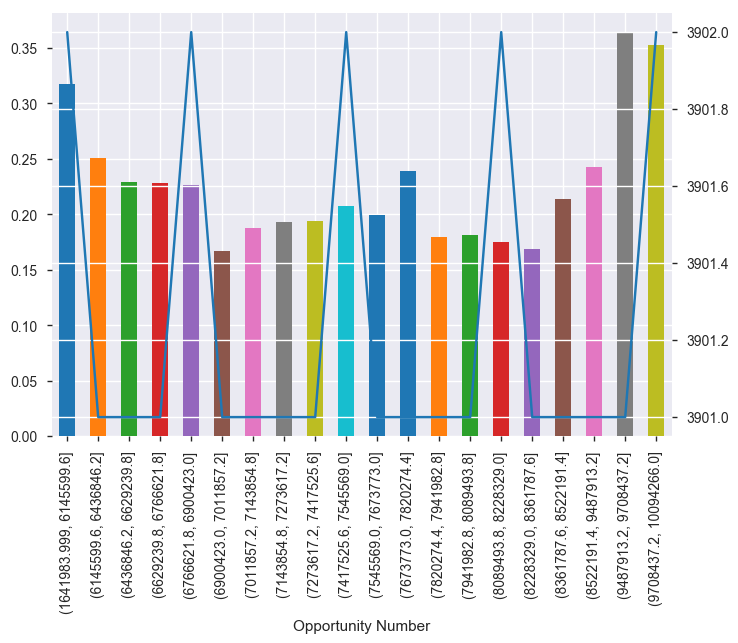

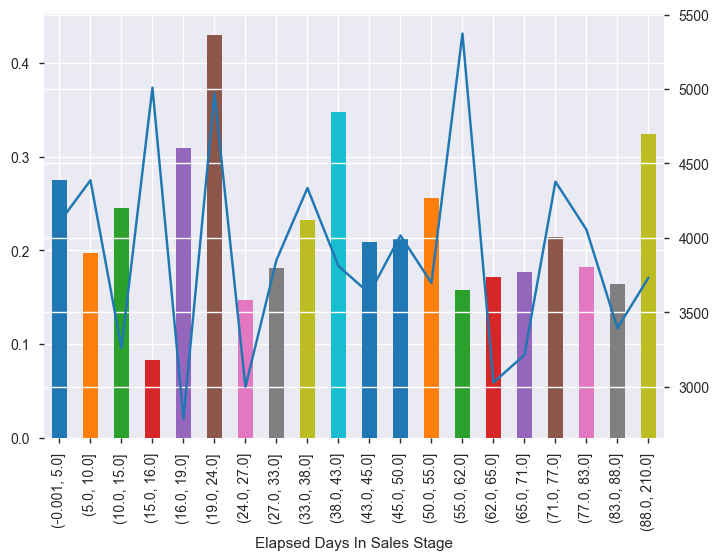

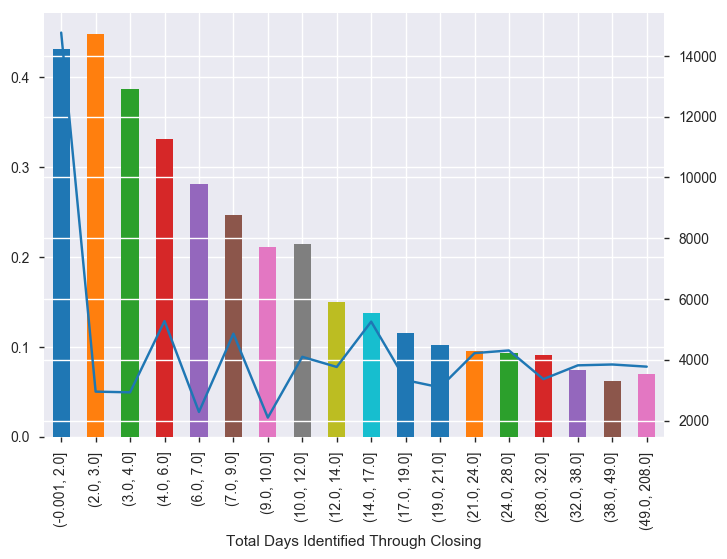

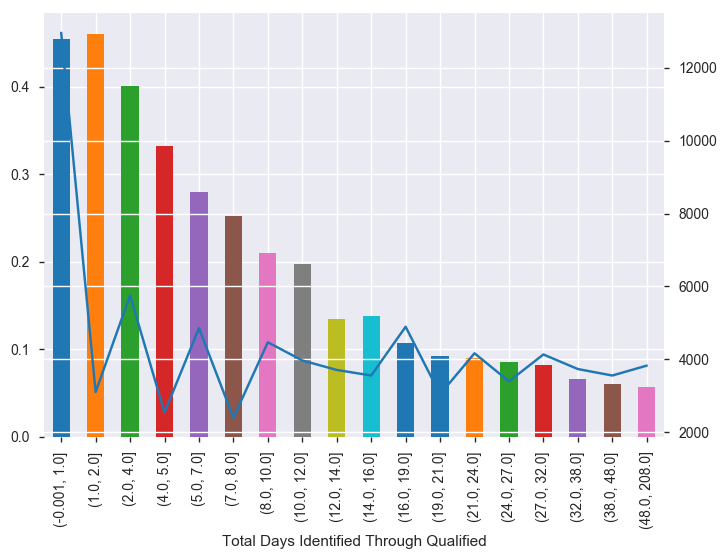

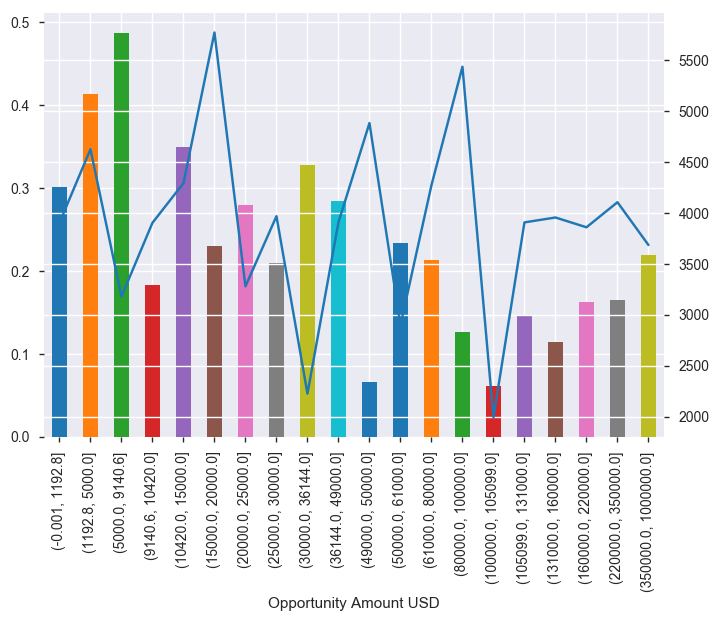

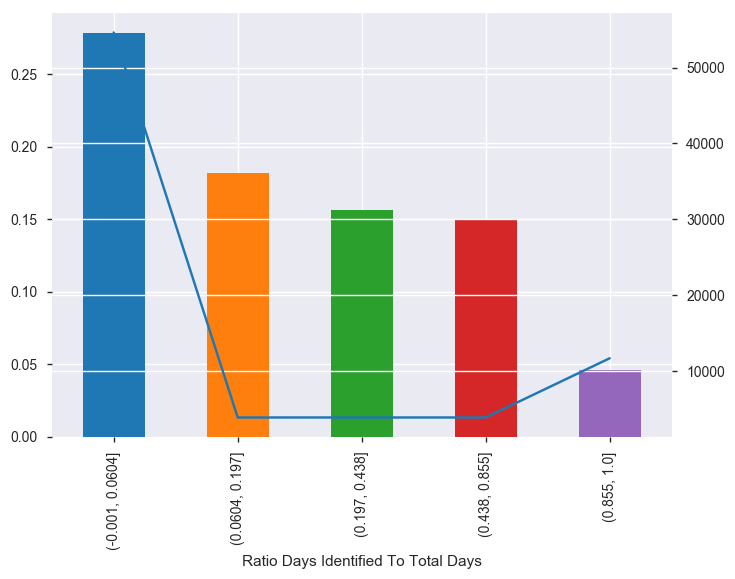

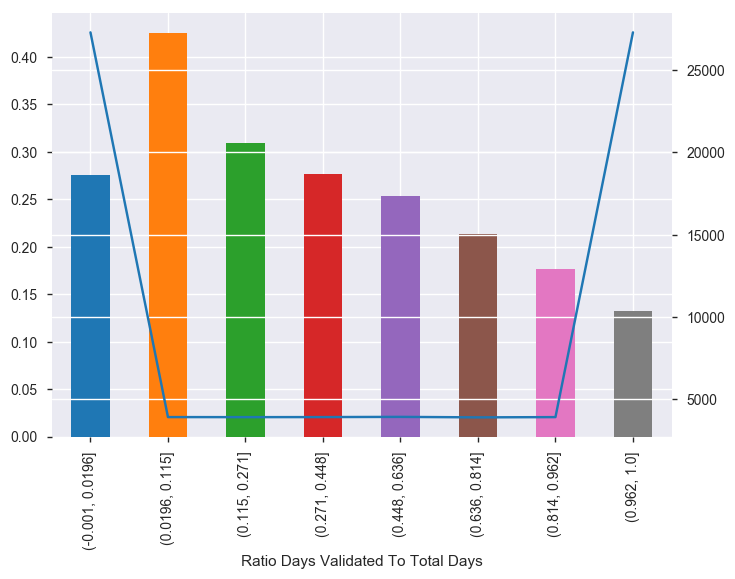

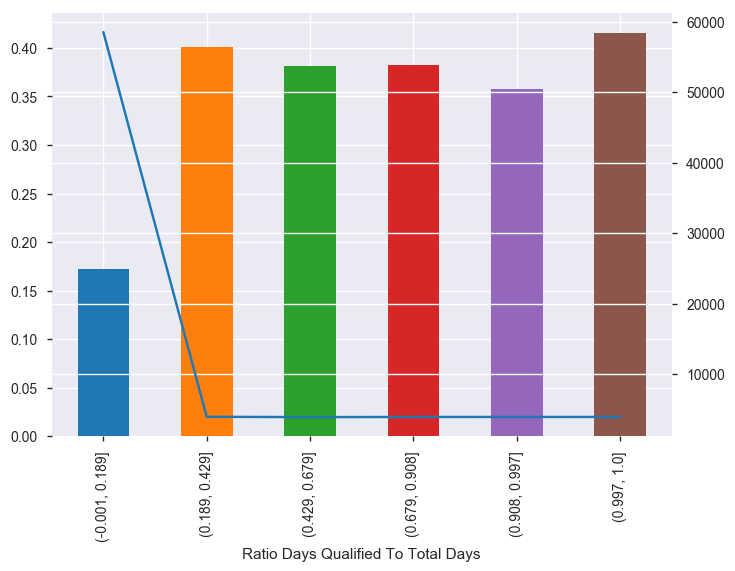

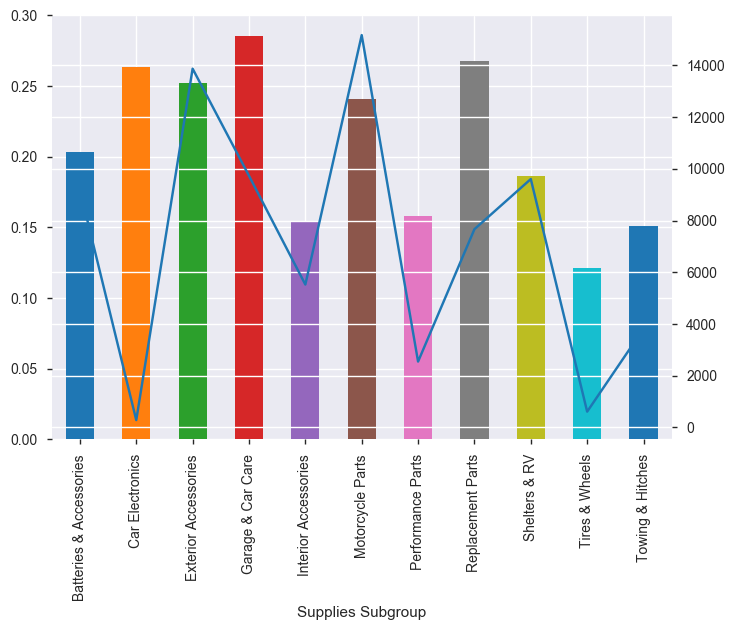

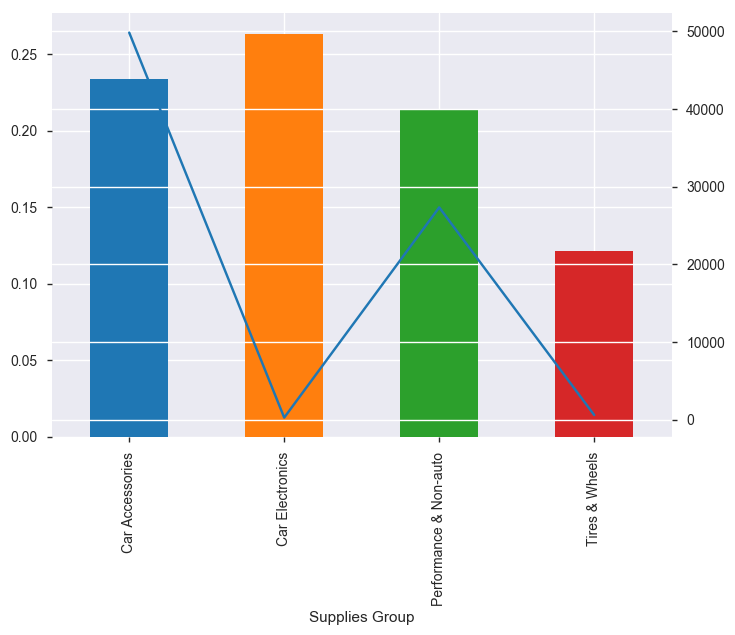

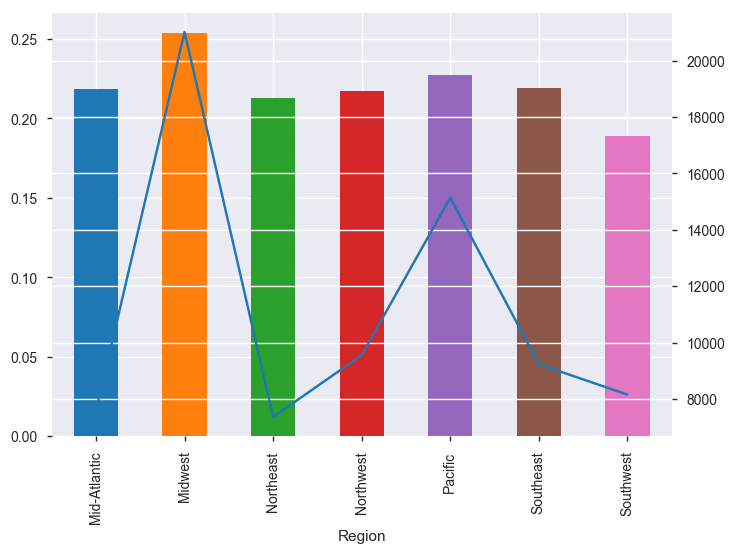

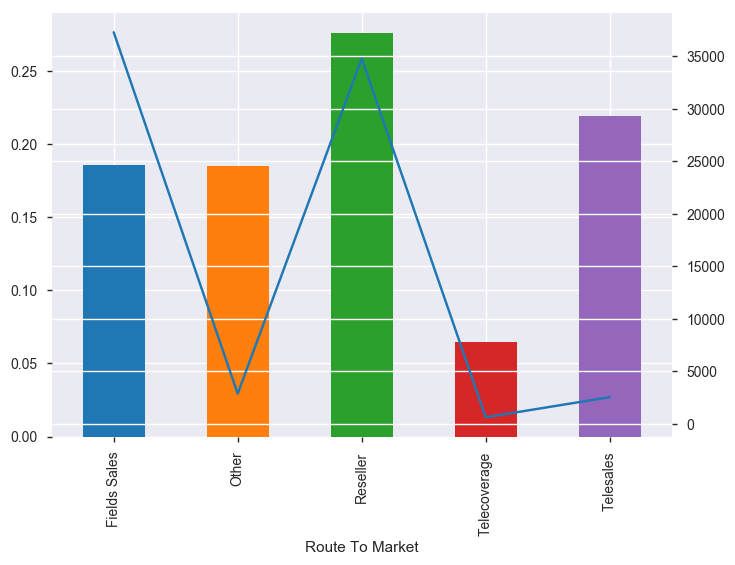

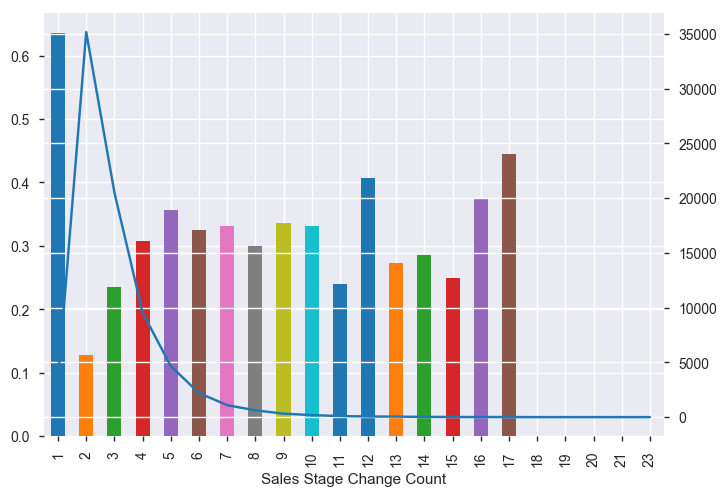

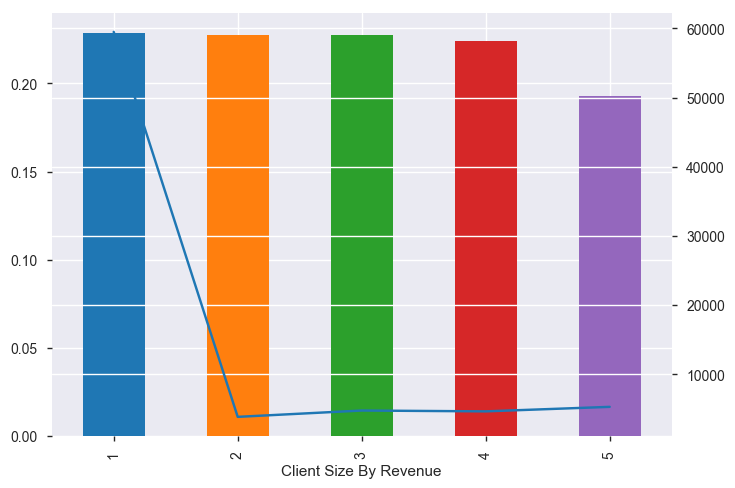

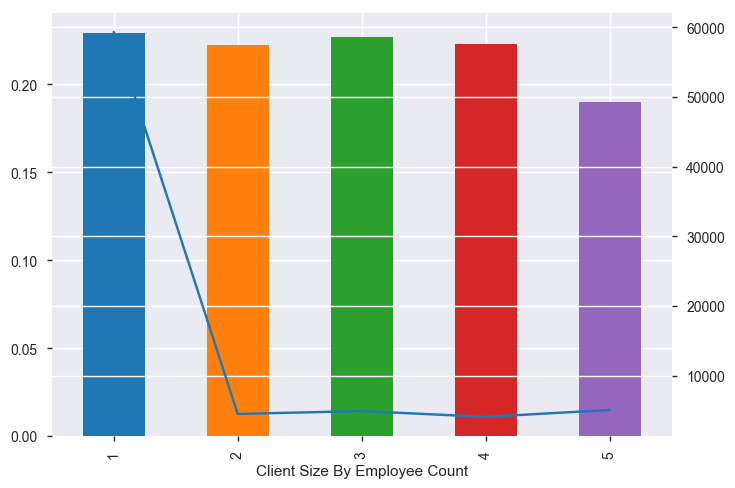

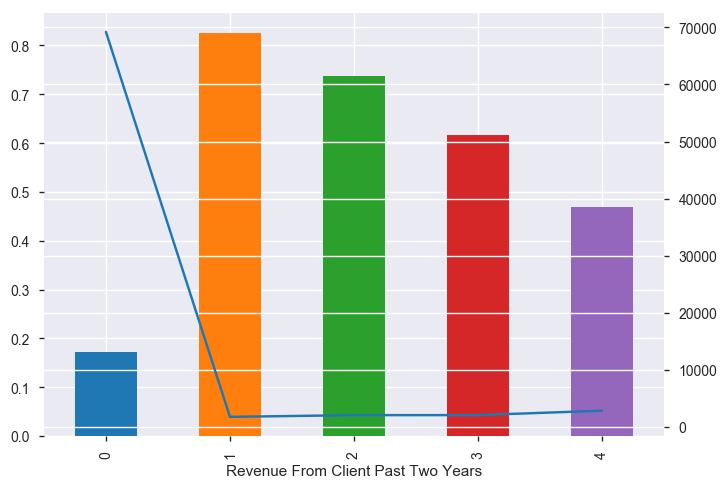

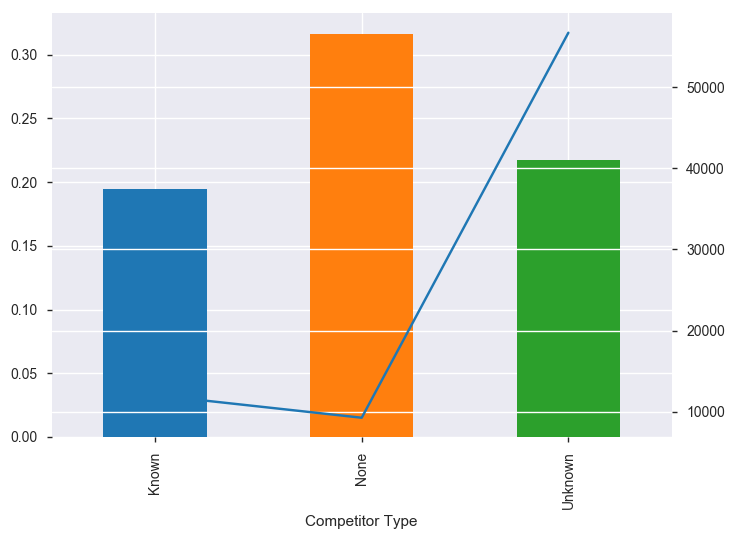

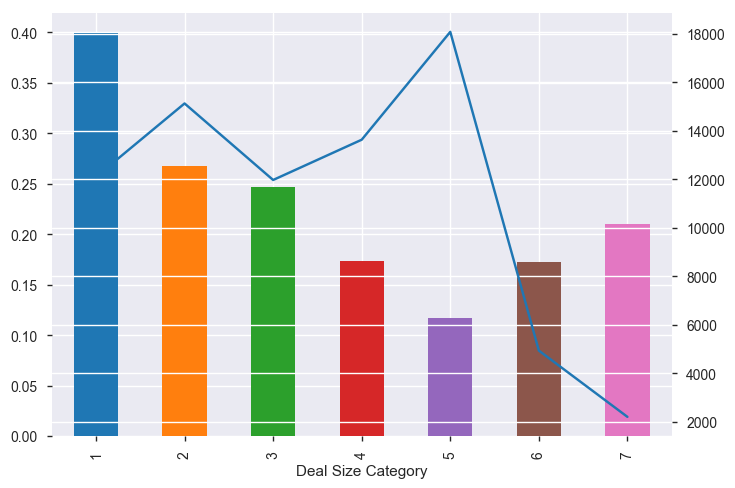

In [8]:
categorical_columns = ['Client Size By Employee Count', 'Client Size By Revenue', 'Deal Size Category',
                       'Revenue From Client Past Two Years', 'Sales Stage Change Count']
X = data.drop(columns=['Opportunity Result'])
X[categorical_columns] = X[categorical_columns].astype('category')
y = (data['Opportunity Result'] == 'Won').rename('y')
plot_success_rate(X, y)

## Insights

- We can use this data to formulate a classification problem to predict 'Opportunity Result' based on rest of the features
- There are 2348 duplicate rows which can probably be dropped from the analysis
- 'Opportunity Amount USD' can be transformed to log scale to make the distribution less skewed and also reduce the range of values
- In 'Competitor Type' column, None values can be replaced with Unknown, as the success rate is almost same for both values
- Column 'Total Days Identified Through Qualified' can probably be dropped from the analysis as it has very high correlation with column 'Total Days Identified Through Closing' and therefore doesn't provide any new information. Instead we can add a column which is difference of 'Total Days Identified Through Closing' and 'Total Days Identified Through Qualified'
- Columns like 'Region', 'Client Size by Revenue', 'Client Size by Employee Count' also have little variation in success rate across values, and are not very useful 
- Columns 'Opportunity Number', 'Elapsed Days In Sales Stage', 'Sales Stage Change Count', and 'Total Days Identified Through Closing' may need to be scaled

# Data Cleaning and Feature Engineering

We will start with very basic data cleaning and feature engineering, and come back to this step if performance of the model is not satisfactory


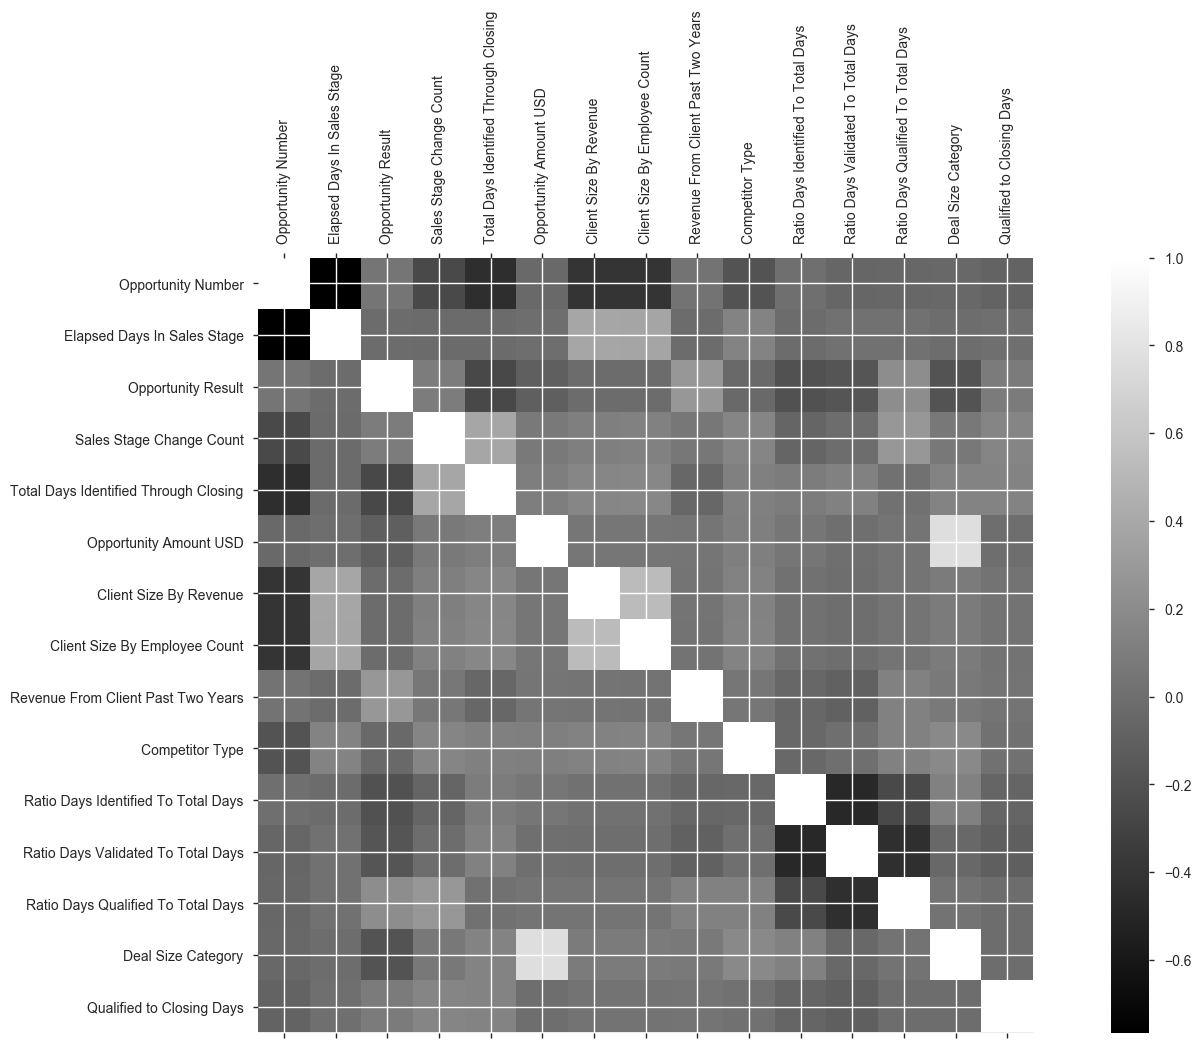

In [12]:
# Data cleaning
X = data.copy()
X['Opportunity Amount USD'] = np.log(X['Opportunity Amount USD'].clip(1))
X['Competitor Type'] = (X['Competitor Type'] == 'Known').astype(int)
X['Qualified to Closing Days'] = X['Total Days Identified Through Closing'] - X['Total Days Identified Through Qualified']
X.drop(columns='Total Days Identified Through Qualified', inplace=True)
X['Opportunity Result'] = (X['Opportunity Result'] == 'Won').astype(int)
num_cols = X.select_dtypes(exclude='object').columns
f = plt.figure(figsize=[20, 10])
plt.matshow(X.corr(), fignum=1, cmap='gray')
plt.colorbar()
_ = plt.xticks(range(len(num_cols)), num_cols, rotation=90)
_ = plt.yticks(range(len(num_cols)), num_cols)

There isn't a strong linear relationship between 'Opportunity Result' and any of the variables

# Model Training

## Model Selection
As we can see from previous analysis, most features have non-linear relationship with 'Opportunity Result'. So simple Logistic Regression model would not work well in this case

Therefore we will use a tree based method in this case. Quite often, xgboost performs better than other tree based models. So we will try a xgboost based model first

## Evaluation Metric
We have 22.6% positive samples in the data, and rest 77.4% are negative samples. As we have a class imbalance here, so we will use Area under the ROC curve or AUC as the evaluation metric because it is less sensitive to class imbalance

## Data Preparation
- There are no missing values, so treatment of missing values is not needed. Also, xgboost accepts missing values in the input
- We will skip feature scaling as tree based methods are not sensitive to feature scaling
- We will use one-hot encoding to convert categorical variables to numerical

In [13]:
# Split into train, val, test
n = len(X)
n_train = int(n * .6)
n_val = int(n * .2)

y = X['Opportunity Result']
X.drop(columns='Opportunity Result', inplace=True)
X = pd.get_dummies(X)
np.random.seed(1)
ind = np.random.permutation(n)
X_train, y_train = X.iloc[ind[:n_train]], y.iloc[ind[:n_train]]
X_val, y_val = X.iloc[ind[n_train:n_train+n_val]], y.iloc[ind[n_train:n_train+n_val]]
X_test, y_test = X.iloc[ind[n_train+n_val:]], y.iloc[ind[n_train+n_val:]]
print(X.shape, X_train.shape, X_val.shape, X_test.shape)

(78025, 41) (46815, 41) (15605, 41) (15605, 41)


In [9]:
# # Scale numerical variables with large value range
# cols_to_scale = ['']

# Convert categorical columns to label encoded
# from sklearn.preprocessing import LabelEncoder
# cat_cols = ['Supplies Subgroup', 'Supplies Group', 'Region', 'Route To Market']

# def label_encode(X, cat_cols, encoders=None):
#     if encoders is None:
#         encoders = []
#         for col in cat_cols:
#             encoder = LabelEncoder()
#             X[col] = encoder.fit_transform(X[col])
#             encoders.append(encoder)
#     else:
#         for col, encoder in zip(cat_cols, encoders):
#             X[col] = encoder.transform(X[col])
#     return X, encoders


In [10]:
# X_train, encoders = label_encode(X_train, cat_cols)
# X_val, _ = label_encode(X_val, cat_cols, encoders)
# X_test, _ = label_encode(X_test, cat_cols, encoders)

In [14]:
import xgboost as xgb
trn_ds = xgb.DMatrix(X_train, y_train)
val_ds = xgb.DMatrix(X_val, y_val)
test_ds = xgb.DMatrix(X_test)
params={
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}
model = xgb.train(params, trn_ds, num_boost_round=1000, evals = [(trn_ds, 'train'), (val_ds, 'val')],
          early_stopping_rounds=3, verbose_eval=50)

[0]	train-auc:0.887439	val-auc:0.884464
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 3 rounds.
[50]	train-auc:0.908641	val-auc:0.904531
[100]	train-auc:0.915763	val-auc:0.911646
[150]	train-auc:0.920165	val-auc:0.915273
[200]	train-auc:0.92355	val-auc:0.91826
[250]	train-auc:0.927179	val-auc:0.921225
[300]	train-auc:0.930341	val-auc:0.923844
[350]	train-auc:0.933215	val-auc:0.926174
[400]	train-auc:0.935795	val-auc:0.928327
[450]	train-auc:0.937947	val-auc:0.930088
[500]	train-auc:0.939763	val-auc:0.931543
[550]	train-auc:0.941604	val-auc:0.932836
[600]	train-auc:0.943398	val-auc:0.933994
[650]	train-auc:0.945056	val-auc:0.935132
[700]	train-auc:0.946445	val-auc:0.935906
[750]	train-auc:0.9477	val-auc:0.936586
[800]	train-auc:0.949145	val-auc:0.937471
[850]	train-auc:0.95033	val-auc:0.938093
[900]	train-auc:0.95141	val-auc:0.938705
[950]	train-auc:0.952376	val-auc:0.939196
[999]	train-auc:0.953313	val-au

In [15]:
from sklearn import metrics

0.9396590597951574


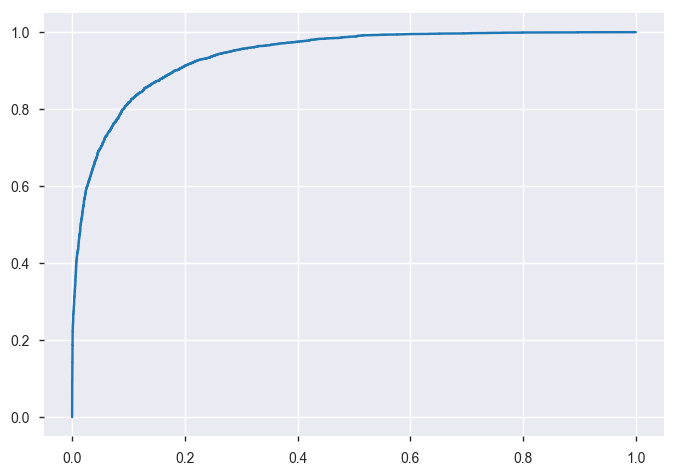

In [16]:
pred_val = model.predict(val_ds)
print(metrics.roc_auc_score(y_val, pred_val))
plt.plot(*metrics.roc_curve(y_val, pred_val)[:2])

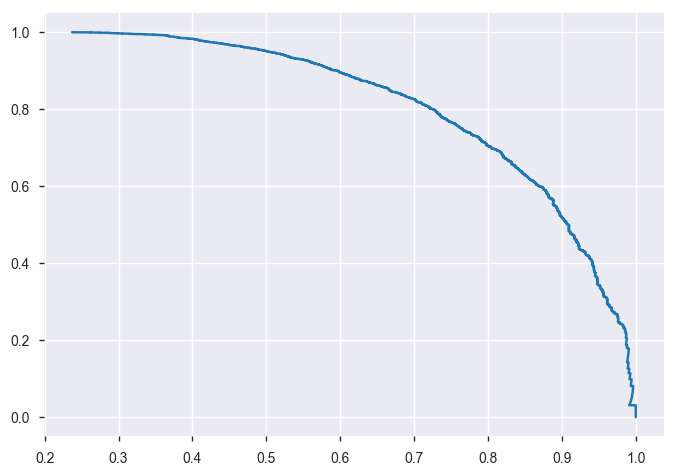

In [17]:
p, r, t = metrics.precision_recall_curve(y_val, pred_val)
prt_data = pd.DataFrame({'precision': p, 'recall': r, 'threshold': np.append(t, 1)})
plt.plot(prt_data.precision, prt_data.recall)

We have around 70% recall at 80% accuracy in the validation data. We will use this threshold value to calculate accuracy metric in the test data

In [18]:
best_p, best_r, best_t = prt_data.loc[(prt_data.precision - 0.8).abs().idxmin()]
print(best_p, best_r, best_t)

0.800063371356147 0.7047167178342172 0.466426819562912


In [19]:
def get_metrics(model, ds, y, t=0.5):
    y_pred = model.predict(ds)
    return [
        metrics.accuracy_score(y, y_pred>=t),
        metrics.log_loss(y, y_pred),
        metrics.roc_auc_score(y, y_pred)
    ]

In [20]:
perf = []
for ds, y in [(trn_ds, y_train), (val_ds, y_val), (test_ds, y_test)]:
    perf.append(get_metrics(model, ds, y, best_t))
perf = pd.DataFrame(perf, index=['train', 'val', 'test'], columns=['accuracy', 'log_loss', 'auc'])
print(perf)

       accuracy  log_loss       auc
train  0.906526  0.227100  0.953313
val    0.891765  0.256035  0.939659
test   0.891701  0.255340  0.938765


# Future Work
- We can further tune hyperparameters of the model using grid search to improve model performance
- We can also experiment with different preprocessing strategies like using weight of evidence to encode categorical variables
- There is scope for engineering lot of features. We can then use feature selection techniques like chi-square test to select important features
- We can try other algorithms including Neural Network based ones to compare the performance
- If possible, include more features/data about clients and products being sold etc.